# Notebook 4: Inference

##  1: Data Loader for Test Dataset


In [ ]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose([ 
    transforms.Resize([224, 224]),                          
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Visualize an example test image, before pre-processing is applied.

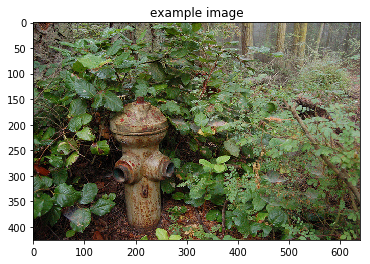

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

orig_image, image = next(iter(data_loader))

plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

## 2: Load Trained Models


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Loading the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (word_embeddings): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

## 3: Sample method is defined in the DecoderRNN class in **model.py**

This method accepts as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image and returns as output a Python list `output`, indicating the predicted sentence.  

* `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence. 

In [ ]:
image = image.to(device)

print("image.shape: ", image.shape)
features = encoder(image).unsqueeze(1)
print("features.shape: ", features.shape)

output = decoder.sample(features)   # Passing the embedded image features through the model to get a predicted caption.
print('example output:', output)

image.shape:  torch.Size([1, 3, 224, 224])
features.shape:  torch.Size([1, 1, 256])
example output: [0, 3, 35, 165, 166, 224, 77, 32, 392, 13, 3, 1402, 18, 1, 18, 1, 1, 110, 13, 717]


## 4: Cleaning up the Captions

The `clean_sentence` function takes a list of integers (corresponding to the variable `output`) as input and returns the corresponding predicted sentence.

In [ ]:
def clean_sentence(output):
    sentence = ''
    for number in output:
        if(number == 0):
            continue
        if(number == 1 or number == 18):
            break
        sentence = sentence + data_loader.dataset.vocab.idx2word[number] + ' '
    #sentence = sentence[:-3] + '.'
    return sentence

In [ ]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

example sentence: a red fire hydrant sitting in the middle of a forest 


## 5: Generate Predictions!

The function (`get_prediction`) loops over images in the test dataset and print the model's predicted caption.

In [ ]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

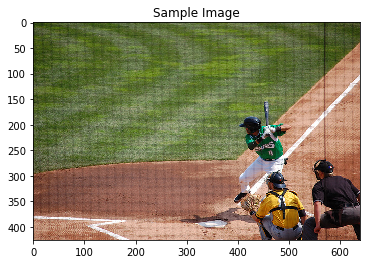

a baseball player holding a bat on a field 


In [ ]:
get_prediction()

### Good predictions

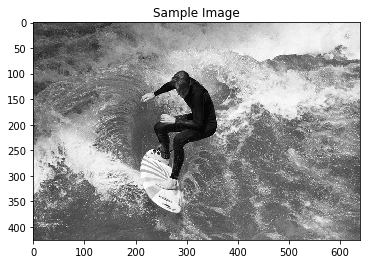

a surfer riding a wave in the ocean 


In [ ]:
get_prediction()

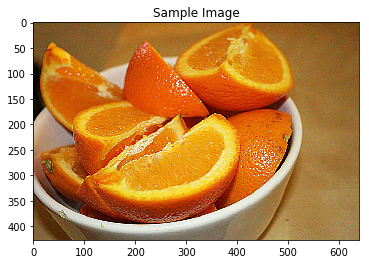

a bowl of oranges on a table 


In [ ]:
get_prediction()

### Bad Predictions

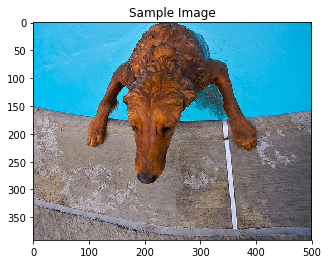

a brown and white dog standing on top of a boat 


In [ ]:
get_prediction()

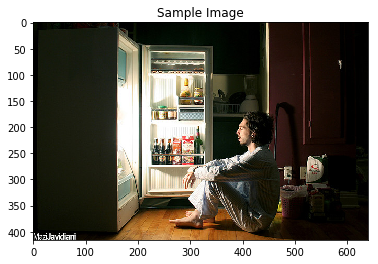

a woman in a kitchen with a refrigerator 


In [ ]:
get_prediction()